In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap

In [2]:
file_path = "C:/Users/Hansal Kumar Singh/OneDrive/Desktop/cs-training.csv"
df = pd.read_csv(file_path)

df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


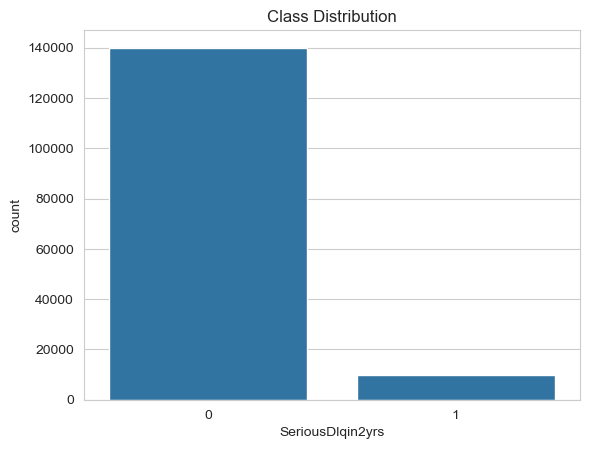

In [3]:
sns.set_style("whitegrid")

sns.countplot(x='SeriousDlqin2yrs', data=df)
plt.title("Class Distribution")
plt.show()

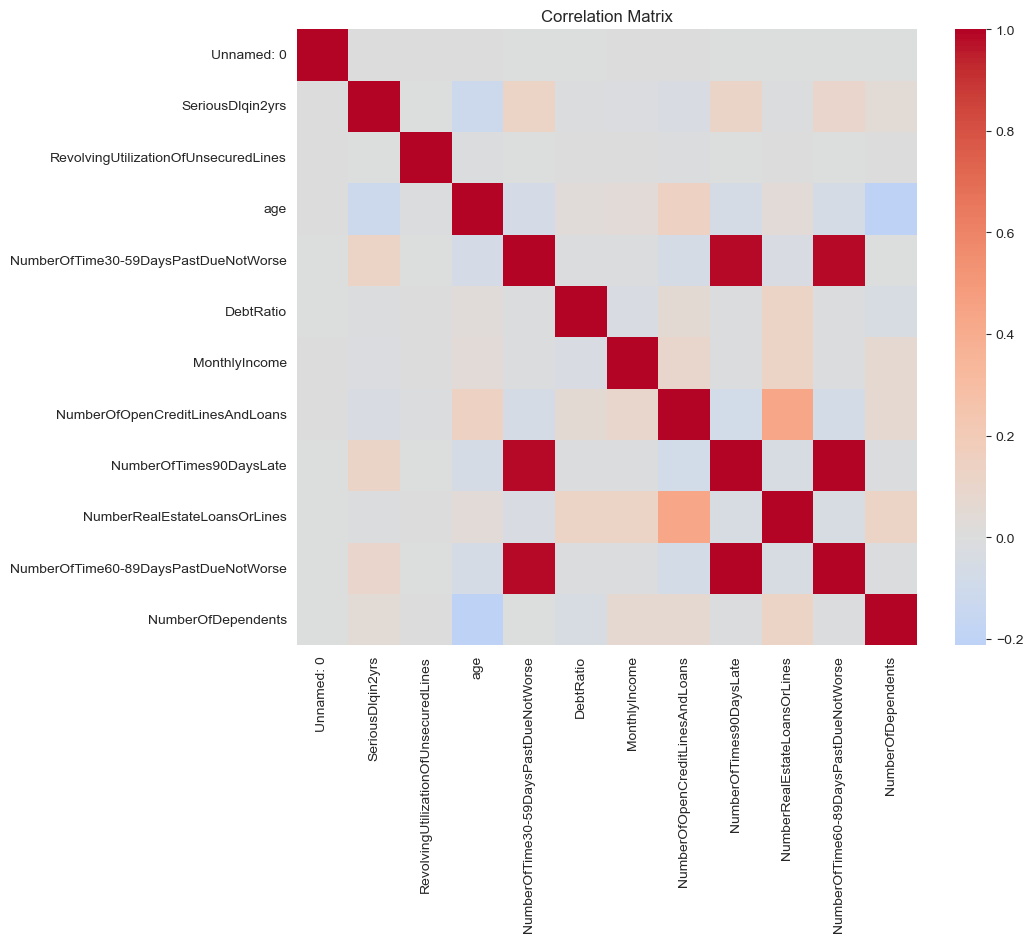

In [4]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

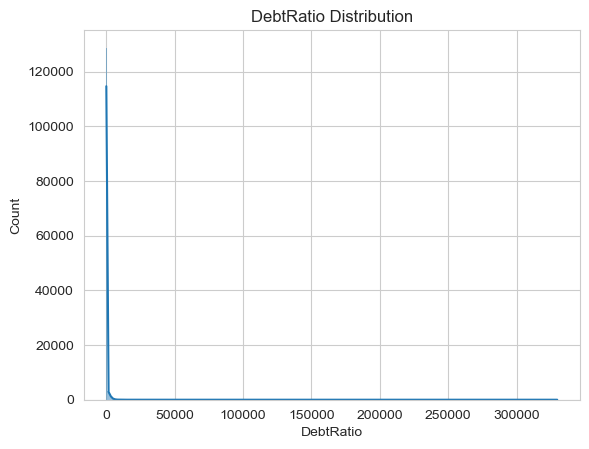

In [5]:
sns.histplot(df['DebtRatio'], kde=True)
plt.title("DebtRatio Distribution")
plt.show()

In [6]:
df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [7]:
df_filled = df.fillna(df.median())
df_filled.isnull().sum()

Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [8]:
df_encoded = pd.get_dummies(df_filled, drop_first=True)
df_encoded.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [9]:
X = df_encoded.drop("SeriousDlqin2yrs", axis=1)
y = df_encoded["SeriousDlqin2yrs"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Base model (same name: xgb_model)
xgb_model = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
)

# Small parameter grid (kept reasonable for speed)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

# Perform tuning
grid_search.fit(X_train, y_train)

# Overwrite xgb_model with best version
xgb_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best CV AUC: 0.8630186869762538


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# SMOTE on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Pipeline: scaling + logistic regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=5000, random_state=42))
])

lr_pipeline.fit(X_train_bal, y_train_bal)

,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

In [17]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Classification report
print(classification_report(y_test, y_pred, zero_division=0))

# AUC
print("AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     27995
           1       0.21      0.78      0.33      2005

    accuracy                           0.79     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.79      0.84     30000

AUC: 0.8686891807808573


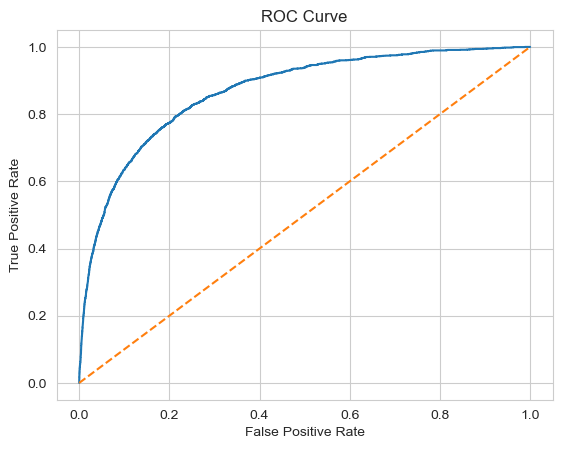

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

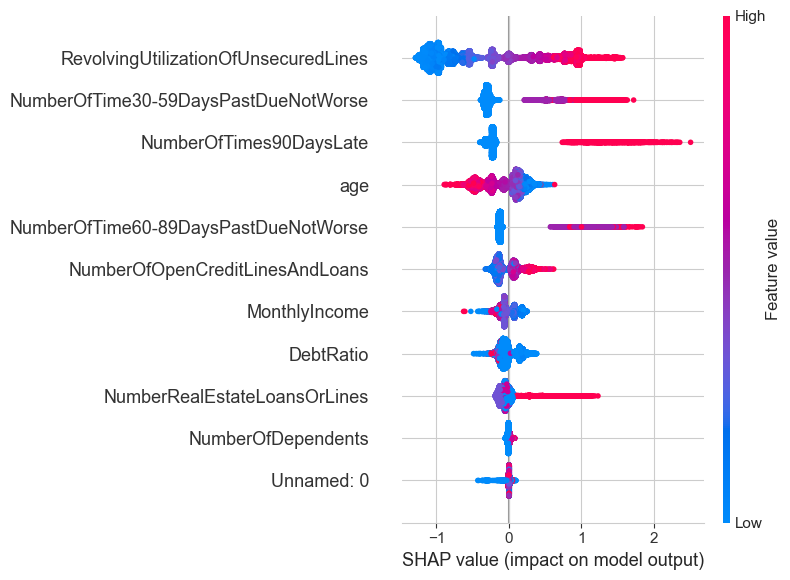

In [19]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [20]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score

# Models dictionary
models = {
    "Logistic Regression": lr_pipeline,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

results = []

# Compare models
for name, model in models.items():
    # Predict on X_test as DataFrame
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Classification report with zero_division to avoid warnings
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    results.append({
        "Model": name,
        "Precision (1)": report["1"]["precision"],
        "Recall (1)": report["1"]["recall"],
        "F1 (1)": report["1"]["f1-score"],
        "AUC": roc_auc_score(y_test, y_prob)
    })

# Create DataFrame for comparison
comparison_df = pd.DataFrame(results)
comparison_df

,Model,Precision (1),Recall (1),F1 (1),AUC
0,Logistic Regression,0.129818,0.656858,0.216790,0.729649
1,Random Forest,0.613678,0.165586,0.260801,0.868088
2,XGBoost,0.212694,0.780549,0.334295,0.868689


In [21]:
from sklearn.metrics import f1_score
import numpy as np

# Predicted probabilities for class 1
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Try thresholds from 0.01 to 0.99
thresholds = np.arange(0.01, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Optimal threshold = max F1
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold for best F1:", optimal_threshold)

Optimal threshold for best F1: 0.75


In [22]:
# Copy original data for final table
final_df = df_filled.copy()  # use the preprocessed filled DataFrame

# Encode categorical variables exactly as in training
final_df_encoded = pd.get_dummies(final_df, drop_first=True)

# Predict PD using trained XGBoost
final_df_encoded['PD'] = xgb_model.predict_proba(final_df_encoded[X_train.columns])[:, 1]

# Assign LGD and EAD from original data columns (replace with actual if you have proper ones)
final_df_encoded['LGD'] = final_df['DebtRatio']       # example proxy
final_df_encoded['EAD'] = final_df['MonthlyIncome']   # example proxy

# Loan Decision using optimal threshold
final_df_encoded['Loan_Decision'] = (final_df_encoded['PD'] < optimal_threshold).astype(int)

# Select final columns
final_table = final_df_encoded[['PD', 'LGD', 'EAD', 'Loan_Decision']]
final_table.head(20)

,PD,LGD,EAD,Loan_Decision
0,0.897577,0.802982,9120.0,0
1,0.594965,0.121876,2600.0,1
2,0.786817,0.085113,3042.0,0
3,0.236872,0.036050,3300.0,1
4,0.660818,0.024926,63588.0,1
5,0.116567,0.375607,3500.0,1
6,0.234236,5710.000000,5400.0,1
7,0.489715,0.209940,3500.0,1
8,0.203254,46.000000,5400.0,1
9,0.342571,0.606291,23684.0,1


In [23]:
import shap
import numpy as np

# Ensure SHAP values are computed for X_test
explainer = shap.TreeExplainer(xgb_model)
shap_values_test = explainer.shap_values(X_test)

# Predicted probabilities
y_prob_test = xgb_model.predict_proba(X_test)[:, 1]

# Function to explain why a loan was rejected
def explain_rejected_loan(i, top_n=3):
    row_shap = shap_values_test[i]       # SHAP values for this loan
    features = X_train.columns           # feature names
    
    # Sort by absolute contribution and pick top_n
    top_indices = np.argsort(np.abs(row_shap))[-top_n:][::-1]
    
    # Prepare explanation with quantitative effect
    top_features = []
    for j in top_indices:
        effect = row_shap[j]
        if effect > 0:
            top_features.append(f"{features[j]} increased PD by {effect:.3f}")
        else:
            top_features.append(f"{features[j]} decreased PD by {abs(effect):.3f}")
    
    pd_value = y_prob_test[i]
    
    return (f"Loan rejected (PD = {pd_value:.3f} ≥ threshold {optimal_threshold:.3f}). "
            f"Top factors contributing to rejection: {', '.join(top_features)}")

# Apply only for rejected loans
for i in range(len(X_test)):
    if y_prob_test[i] >= optimal_threshold:
        print(explain_rejected_loan(i))
        print("---------------------------------------------------")

Loan rejected (PD = 0.959 ≥ threshold 0.750). Top factors contributing to rejection: NumberOfTimes90DaysLate increased PD by 1.238, NumberOfTime60-89DaysPastDueNotWorse increased PD by 0.868, RevolvingUtilizationOfUnsecuredLines increased PD by 0.522
---------------------------------------------------
Loan rejected (PD = 0.928 ≥ threshold 0.750). Top factors contributing to rejection: NumberOfTimes90DaysLate increased PD by 1.098, NumberOfTime60-89DaysPastDueNotWorse increased PD by 0.945, RevolvingUtilizationOfUnsecuredLines increased PD by 0.817
---------------------------------------------------
Loan rejected (PD = 0.816 ≥ threshold 0.750). Top factors contributing to rejection: NumberOfTime30-59DaysPastDueNotWorse increased PD by 1.098, DebtRatio increased PD by 0.320, NumberOfTimes90DaysLate decreased PD by 0.250
---------------------------------------------------
Loan rejected (PD = 0.850 ≥ threshold 0.750). Top factors contributing to rejection: NumberOfTime30-59DaysPastDueNotWo